In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diskmodels import profilecirc
from diskfit import likelihood, utils
from scipy.optimize import minimize
import emcee

z = 0.0146
cont = np.array([-2.57426216e-06, -4.41129826e+00,  8.08577702e-16])

#### Functions

In [2]:
def power_law(wl, A, k, C):
    return A*(wl/(1+z))**k+C

def plot_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, w, y, yerr, lines, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    return diskout,narrowmodel

def model_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, w, y, yerr, lines, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    model = np.sum((diskout,narrowmodel),axis=0)
    return model

class log_prior(object):
    def __init__(self, mins, maxes):
        self.mins = mins
        self.maxes = maxes
    def __call__(self, theta): 

        if np.any(theta<self.mins) or np.any(theta>self.maxes): 
            return -np.inf
        return 0.0

class logprob_circ_fixeddoublet_freeamplitudes_Halpha(object):
    def __init__(self, x, y, yerr, lines, fixed, fitted, mins, maxes):   
        self.x = x
        self.y = y
        self.yerr = yerr
        self.lines = lines
        self.fixed = fixed
        self.fitted = fitted
        self.mins = mins
        self.maxes = maxes
        self.log_prior = log_prior(self.mins, self.maxes)
    def __call__(self,theta):
        lp = self.log_prior(theta)
        like = loglikelihood_circ_fixeddoublet_freeamplitudes_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.fixed, self.fitted)
        if np.any(np.isnan(like)):
            #return np.full(len(like),1e10+lp)
            return -np.inf   
        #print(like,lp)
        return like+lp 
    def test(self,theta):
        modelout = model_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.fixed, self.fitted) 
        return modelout 
    def plot(self,theta):
        diskout,narrowout = plot_linefit_circ_fixeddoublet_freeamplitudes_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.fixed, self.fitted) 
        return diskout,narrowout

def loglikelihood_circ_fixeddoublet_freeamplitudes_Halpha(theta, w, y, yerr, lines, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    model = np.sum((diskout,narrowmodel),axis=0)
    sigma2 = yerr**2  
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

#### Spec

In [32]:
fn = '../../spectra/AT2019qiz.txt'
wl, flux = np.loadtxt(fn, usecols=(0, 1), unpack=True)
flux -= power_law(wl, *cont)
flux *= 1e17

olambda = 6563
wavemin = 6500
wavemax = 6630
wave = wl/(1+z)
indwave = np.argwhere((wave>wavemin)&(wave<wavemax)&~np.isnan(flux))[:,0]
wl = np.asarray(wl[indwave],dtype=np.float64)
fluxerr = np.ones(flux.shape)*np.median(np.abs(flux[1:]-flux[:-1]))
flux = flux[indwave]
fluxerr = 3*fluxerr[indwave]
npix = wl.shape[0]

In [33]:
# Integration, units, normalization
maxstep = 400 # Maximum number of integration steps (integer)
nstep = 100 # integration steps (integer, </= 400)
relativistic = 'y' #  include relativistic effects? (y/n) [y]
normalization = 'max' # profile normalization scheme (max/flux/none) [max]

# Circular disk size and emission properties
q1 = 1.9 #inner emissivity powerlaw index
q2 = 1.9 #outer emissivity powerlaw index
xib = 0.6 #power-law index break radius (XIB=0 causes Q=Q2 throughout)

# Wind properties
t0 = 1e-8   # optical depth normalization (0=no wind)
eta = 0.8 #optical depth power-law index
anglam = 8 #wind opening angle (degrees)
version = 'f' #formula for escape probability (f=Flohic, m=Murray)

# Spiral arms
amp = 1e-12 #contrast of spiral arm (0=no arms)
narms = 1 #number of arms (integer)
aobs = 95 #spiral orientation (degrees, +ve=outer, -ve=inner)
pitch = -20 #pitch angle of spiral pattern (+ve=leading, -ve=trailing)
width = 40 #angular width of arm (degrees)
xispin = 0 #inner spiral arm radius radius (GM/c^2, 0=XI1)
xispout = 0 #outer spiral arm radius radius (GM/c^2, 0=XI2)

#Narrow lines
narrowwidth = 1.7 # Width of component 1 of broad line in Angstroms
narrowwidth2 = 0.9 # Width of component 2 of broad line in Angstroms
narrowfrac = 0.2 #Amplitude fraction the two narrow line components

In [34]:
angimin, angimax = -360, 360
xi1min, xi1max = 50, 10000
xi2min, xi2max = 100, 10000
broadmin, broadmax = 0, 2000
ampmin, ampmax = -1e-12, 5.0
pitchmin, pitchmax = -60, 60
aobsmin, aobsmax = -720, 360*3
narrowwidthmin, narrowwidthmax = 0.1, 15.0
narrowwidth2min, narrowwidth2max = 0.1, 12.0
narrowfracmin, narrowfracmax = 0.1, 5.0
anglammin, anglammax = 2.0, 40
t0min, t0max = 1e-10, 1e2
etamin, etamax = -1.5, 1.5
Halphafluxmin, Halphafluxmax = 12, 300
NIIbfluxmin, NIIbfluxmax = 0.0, 8
SIIbfluxmin, SIIbfluxmax = 0.0, 300
diskfluxmin, diskfluxmax = 1, 500

diskmins = [
xi1min,xi2min,broadmin,angimin,narrowfracmin,narrowwidthmin,narrowwidth2min,anglammin,t0min,etamin,Halphafluxmin,NIIbfluxmin,SIIbfluxmin,diskfluxmin]
diskmax = [
xi1max,xi2max,broadmax,angimax,narrowfracmax,narrowwidthmax,narrowwidth2max,anglammax,t0max,etamax,Halphafluxmax,NIIbfluxmax,SIIbfluxmax,diskfluxmax]

In [168]:
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]
NIIb_NIIa = 2.95
SIIb_SIIa = 1.3
ratios = [NIIb_NIIa,SIIb_SIIa]
Halphaflux = 32
NIIbflux = 2
diskflux = 11
SIIbflux = 8

In [169]:
angi = 6 #disk inclination angle (degrees)
xi1 = 1000 #inner disk radius (GM/c^2)
xi2 = 5000 #outer disk radius (multiple of xi1)
broad = 200 #broadening parameter (km/s)

fitted_labels = ['xi1','xi2','broad','angi','narrowfrac','narrowwidth','narrowwidth2','anglam','t0','eta','Halphaflux','NIIbflux','SIIbflux','diskflux']
initial = [xi1,xi2,broad,angi,narrowfrac,narrowwidth,narrowwidth2,anglam,t0,eta,Halphaflux,NIIbflux,SIIbflux,diskflux]
fitted = dict(zip(fitted_labels,initial))

fixed_labels = ['z','ratios','q1','q2','xib','maxstep','version','amp','narms','aobs','pitch','width','xispin','xispout','nstep','relativistic','olambda','npix']
fixed_values = [z,ratios,q1,q2,xib,maxstep,version,amp,narms,aobs,pitch,width,xispin,xispout,nstep,relativistic,olambda,npix]
fixed = dict(zip(fixed_labels,fixed_values))

In [170]:
modelguess = model_linefit_circ_fixeddoublet_freeamplitudes_Halpha(initial, wl, flux, fluxerr, lines, fixed, fitted)
disk,narrowlines= plot_linefit_circ_fixeddoublet_freeamplitudes_Halpha(initial, wl, flux, fluxerr, lines, fixed, fitted)

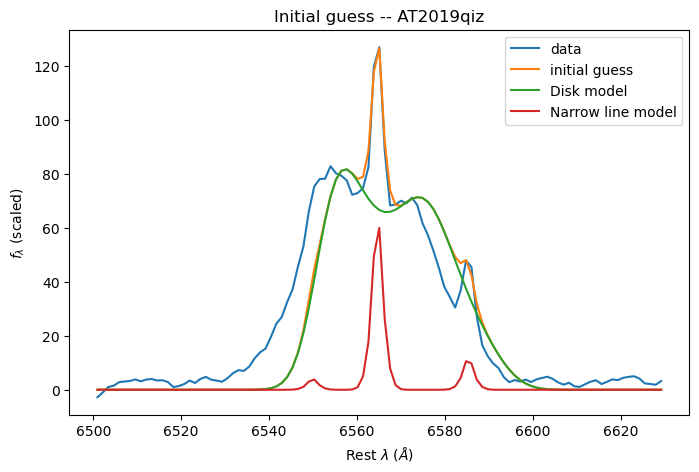

In [171]:
plt.figure(figsize=(8,5))
plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.plot(wl/(1+fixed['z']),modelguess,label='initial guess')
plt.plot(wl/(1+fixed['z']),disk,label='Disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='Narrow line model')
plt.xlabel('Rest $\lambda$ ($\AA$)'); plt.ylabel('$f_{\lambda}$ (scaled)')
plt.title('Initial guess -- AT2019qiz'); plt.legend(); plt.show()

In [172]:
lp = logprob_circ_fixeddoublet_freeamplitudes_Halpha(wl, flux, fluxerr, lines, fixed, fitted, diskmins, diskmax)

In [173]:
nll = lambda *args: -lp(*args)
soln = minimize(nll, initial, method='Nelder-Mead')
modelfit = lp.test(soln.x)

print('Best-fit parameter values:', soln.x)

Best-fit parameter values: [1.32608328e+03 9.99935420e+03 2.39144613e+02 8.65050750e+00
 1.04744049e-01 1.28338043e+00 9.58769201e-01 2.32449878e+00
 1.17960561e-08 5.84706232e-01 3.41820375e+01 1.61485271e+00
 6.79902919e+00 7.62834360e+00]


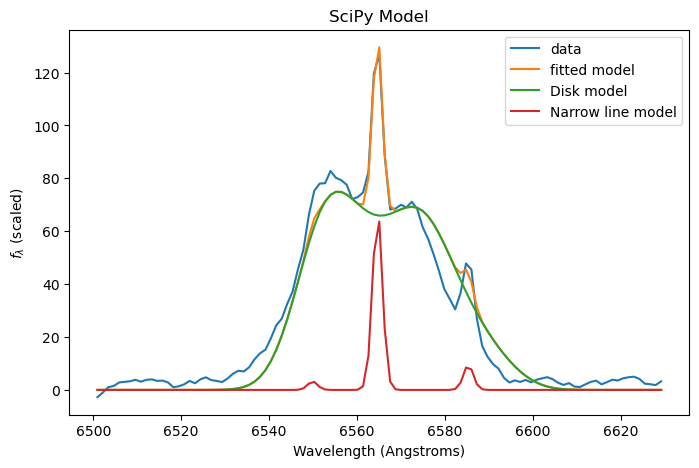

In [176]:
disk,narrowlines = lp.plot(soln.x)
plt.figure(figsize=(8,5))
plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.plot(wl/(1+fixed['z']),modelfit,label='fitted model')
plt.plot(wl/(1+fixed['z']),disk,label='Disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='Narrow line model')
plt.xlabel('Wavelength (Angstroms)'); plt.ylabel('$f_{\lambda}$ (scaled)')
plt.title('SciPy Model'); plt.legend(); plt.show()

In [178]:
pos = soln.x + 5e-1 * soln.x * np.random.randn(50, soln.x.shape[0])
nwalkers, ndim = pos.shape
filename ='emcee.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lp, args=(), backend=backend
    )
sampler.run_mcmc(pos, 2500, progress=True)

 51%|█████     | 1274/2500 [41:15<39:45,  1.95s/it] /tmp/ipykernel_1510847/284404969.py:101: RuntimeWarning: overflow encountered in square
  return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
100%|██████████| 2500/2500 [1:26:24<00:00,  2.07s/it]


State([[ 6.30291975e+03  9.51246375e+03  3.76820332e+02  1.13708086e+01
   2.66200790e-01  1.19863822e+00  8.91192140e-01  3.85671943e+00
   4.24427427e-07 -3.86753494e-02  2.83125752e+01  4.61768978e+00
   4.91841580e+01  2.24418177e+01]
 [ 6.32658265e+03  9.66721170e+03  3.88544071e+02  1.12933839e+01
   6.99518902e-01  9.87021016e-01  9.63522070e-01  4.16817172e+00
   6.25996612e-08  4.83245884e-01  3.23164950e+01  3.44706719e+00
   9.96707544e+01  2.06888706e+01]
 [ 6.39778689e+03  9.61147395e+03  3.60824106e+02  1.16687653e+01
   1.83159761e-01  1.03126427e+00  1.12635077e+00  2.57302897e+00
   5.10106581e-07 -1.20452248e+00  2.92127362e+01  3.10744538e+00
   1.10512664e+02  2.35991005e+01]
 [ 6.78943025e+02  1.58664074e+04  2.17495373e+02  1.24319913e+01
   1.10695669e-01  9.43615073e-01  1.25026039e+00  4.44409635e+00
   1.92071313e-08  9.18145981e-01  4.08988312e+01  2.71942226e+00
   1.10480619e+01  1.50957823e+01]
 [ 6.79112983e+02  1.47928511e+04  5.25171125e+02  1.88747390e

In [179]:
from IPython.display import display, Math
flat_samples = sampler.get_chain(discard=20, flat=True)
mcmc_soln=[]
for i,l in enumerate(fitted_labels):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], fitted_labels[i])
    display(Math(txt))
    
    mcmc_soln.append(mcmc[1])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

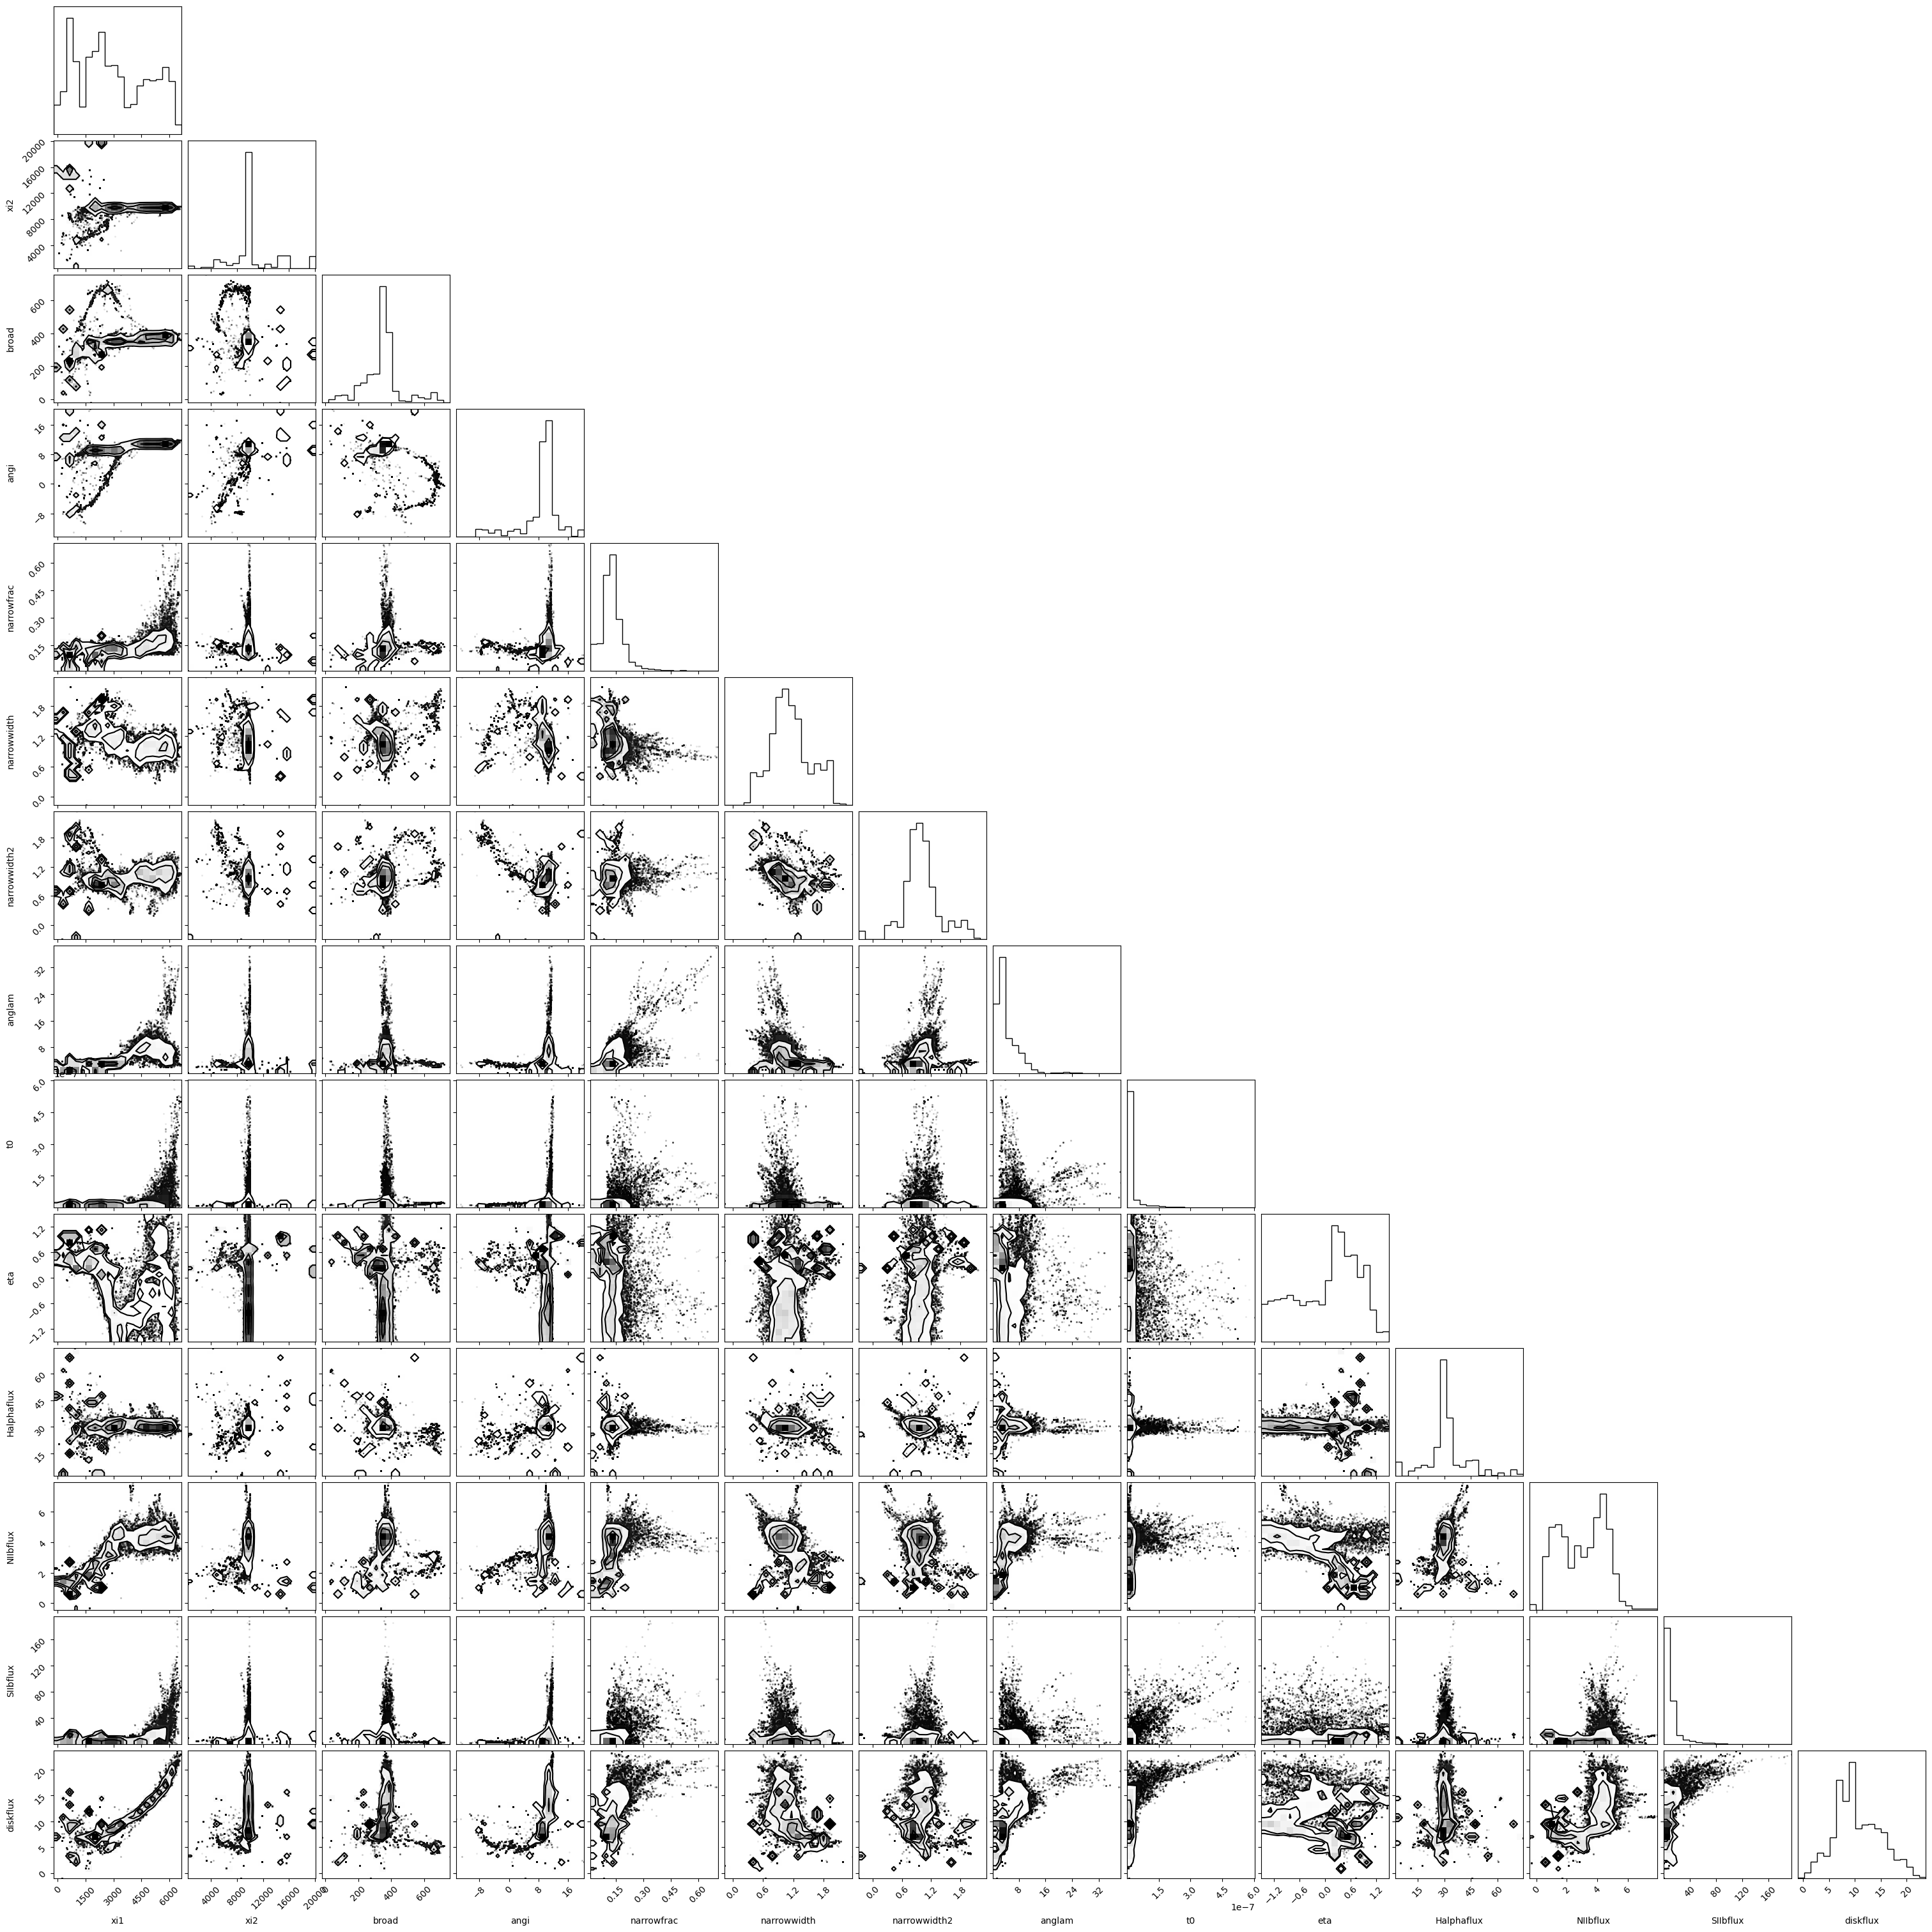

In [180]:
import corner
fig = corner.corner(
            flat_samples, labels=fitted_labels)
plt.show()

<Figure size 600x600 with 0 Axes>

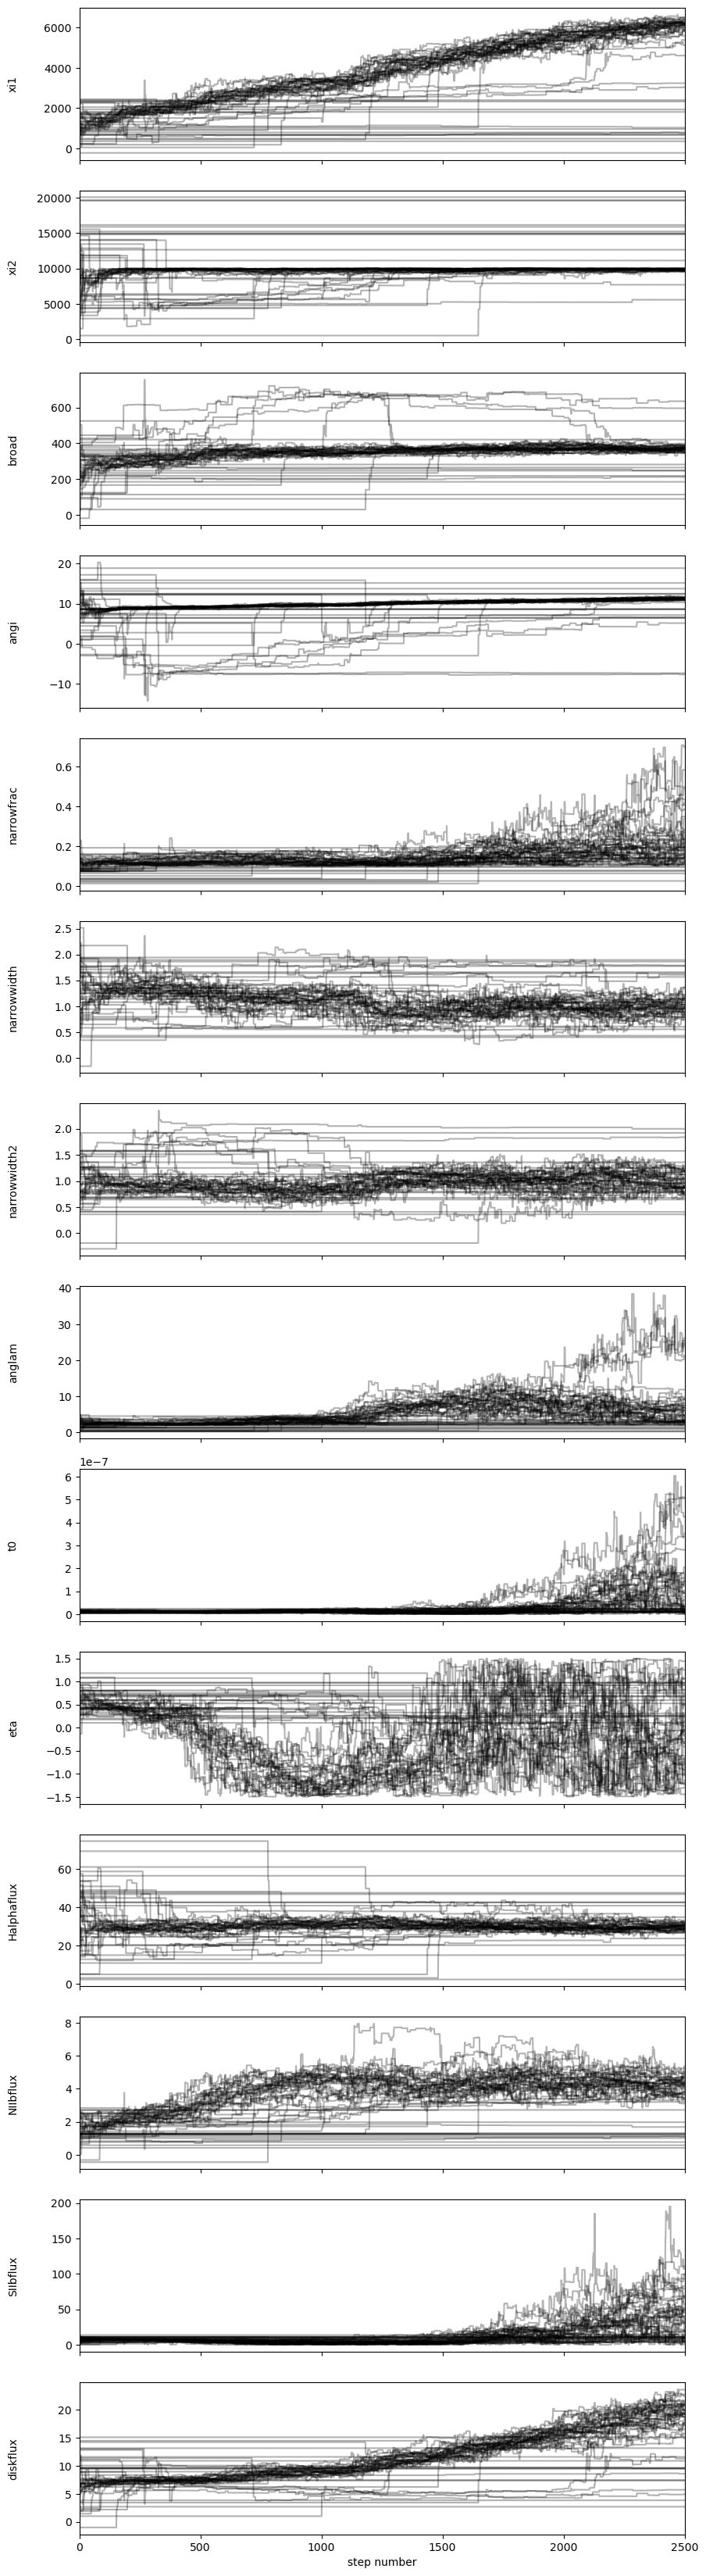

In [181]:
plt.figure(figsize=(6,6))
fig, axes = plt.subplots(soln.x.shape[0], figsize=(10,3*soln.x.shape[0]), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(fitted_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
plt.show()